In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
from numpy import linalg as LA
from scipy.spatial import distance

PATH_YANGNET = '/Users/lauradriscoll/Documents/code/yangnet/training' #'/home/laura/code/yangnet/training'
sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools

from tools_lnd import gen_trials_from_model_dir, gen_X_from_model_dir, gen_X_from_model_dir_epoch, name_best_ckpt, find_ckpts, get_model_params

/Users/lauradriscoll/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
trial = {}
fpf_dict = {}
rule_set = ['delaygo','delayanti']
filename = 'go1_0.0.npy'
model_n = 1

for rule in rule_set:
    dir_specific_all = 'grad_norm_l2h000001'
    model_dir = os.path.join('/Users/lauradriscoll/Documents/data/rnn/multitask/lowD/',dir_specific_all,'most',str(model_n))
    save_dir = os.path.join(model_dir,'fixed_pts',rule)
    
    fpf_dict[rule] = np.load(os.path.join(save_dir,filename)).item()
    trial[rule] = gen_trials_from_model_dir(model_dir,rule)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2h000001/most/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2h000001/most/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradrisco

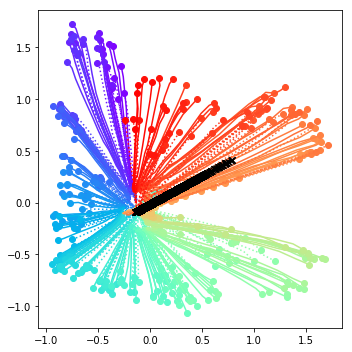

In [58]:
fig = plt.figure(figsize=(5, 5),tight_layout=True,facecolor='white')
cmap=plt.get_cmap('rainbow')
qmap=plt.get_cmap('hot')

rule = 'delaygo'
skip_trials = 2
T,S,_ = np.shape(trial[rule].x)
t1 = trial[rule].epochs['delay1'][1]
t2 = trial[rule].epochs['go1'][1]
trial_set = range(0,S,2)
shift_ind = len(trial_set)#int(S/skip_trials)

pca = PCA()
X = fpf_dict[rule_set[0]]['state_traj'][trial_set,:,:]

X_pca = pca.fit_transform(X.reshape((np.shape(X)[0]*np.shape(X)[1], np.shape(X)[2])))

X = np.concatenate((fpf_dict[rule_set[0]]['state_traj'][trial_set,:,:],
                    fpf_dict[rule_set[1]]['state_traj'][trial_set,:,:]),axis = 0)

X_trials = pca.transform(X[:,t1,:])

pc_ind0 = 0
pc_ind1 = 1


for t in range(0,len(trial_set)):
    c = cmap(t/len(trial_set))
    X_trial = pca.transform(X[t,:t2,:])
    plt.plot(X_trials[t,pc_ind0],X_trials[t,pc_ind1],'o',c = c)
    plt.plot(X_trial[t1:T,pc_ind0],X_trial[t1:T,pc_ind1],'-',c = c)
    
    X_trial = pca.transform(X[len(trial_set)+t,:t2,:])
    plt.plot(X_trials[len(trial_set)+t,pc_ind0],X_trials[len(trial_set)+t,pc_ind1],'o',c = c)
    plt.plot(X_trial[t1:T,pc_ind0],X_trial[t1:T,pc_ind1],':',c = c)
    
for xi in range(len(fpf_dict[rule]['xstar'])):
    c = qmap(xi/len(fpf_dict[rule]['xstar']))
    xstar_pca = pca.transform(np.expand_dims(fpf_dict['delaygo']['xstar'][xi],axis = 1))
    plt.plot(xstar_pca[:,pc_ind0],xstar_pca[:,pc_ind1],'xk')
    
    xstar_pca = pca.transform(np.expand_dims(fpf_dict['delayanti']['xstar'][xi],axis = 1))
    plt.plot(xstar_pca[:,pc_ind0],xstar_pca[:,pc_ind1],'xk')
        
plt.show()

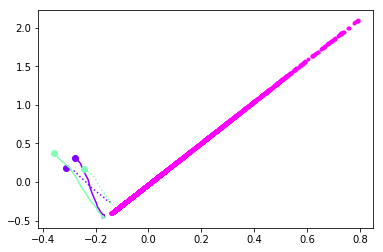

In [76]:
def plot_sitch(pc_ind0,pc_ind1,x1_red):
    
#     pca = PCA()
#     X = fpf_dict[rule_set[0]]['state_traj'][trial_set,:,:]
#     X_pca = pca.fit_transform(X.reshape((np.shape(X)[0]*np.shape(X)[1], np.shape(X)[2])))
#     X = np.concatenate((fpf_dict[rule_set[0]]['state_traj'][range(0,S,2),:,:],
#                     fpf_dict[rule_set[1]]['state_traj'][range(0,S,2),:,:]),axis = 0)
    qmap=plt.get_cmap('cool')
    max_map = -np.max(np.log(fpf_dict['delaygo']['qstar']))
    qvals = -np.log(fpf_dict['delaygo']['qstar'])
    
    for xi in range(len(fpf_dict[rule]['xstar'])):
        c= qmap(qvals[xi]/max_map) 
        xstar_pca = pca.transform(np.expand_dims(fpf_dict['delaygo']['xstar'][xi],axis = 1))
        plt.plot(xstar_pca[:,pc_ind0],xstar_pca[:,pc_ind1],'.',color = c)

        xstar_pca = pca.transform(np.expand_dims(fpf_dict['delayanti']['xstar'][xi],axis = 1))
        plt.plot(xstar_pca[:,pc_ind0],xstar_pca[:,pc_ind1],'.',color = c)

    for t in range(0,len(trial_set)):
        c = cmap(t/len(trial_set))
        X_trial = pca.transform(X[t,:t2,:])
        plt.plot(X_trials[t,pc_ind0],X_trials[t,pc_ind1],'o',c = c)
        plt.plot(X_trial[t1:T,pc_ind0],X_trial[t1:T,pc_ind1],'-',c = c)

        X_trial = pca.transform(X[shift_ind+t,:t2,:])
        plt.plot(X_trials[shift_ind+t,pc_ind0],X_trials[shift_ind+t,pc_ind1],'o',c = c)
        plt.plot(X_trial[t1:T,pc_ind0],X_trial[t1:T,pc_ind1],':',c = c)
    
plot_sitch(0,2,20)
plt.show()

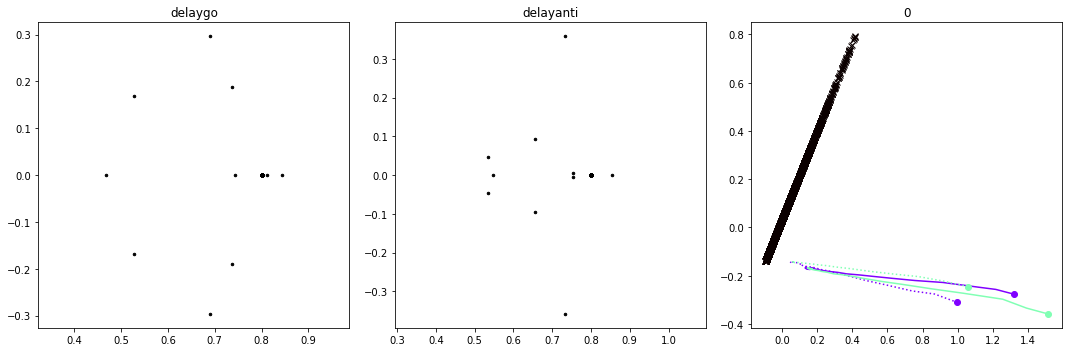

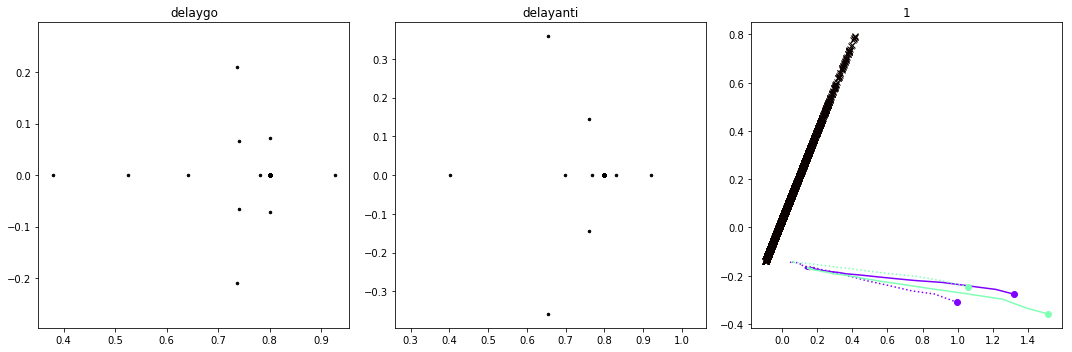

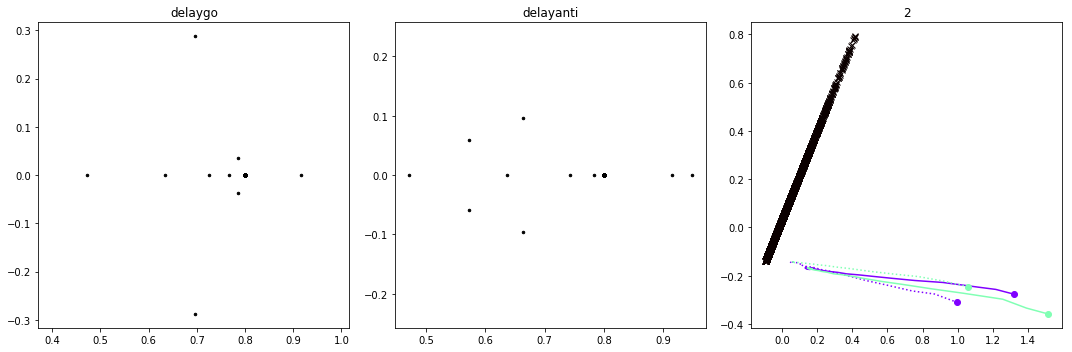

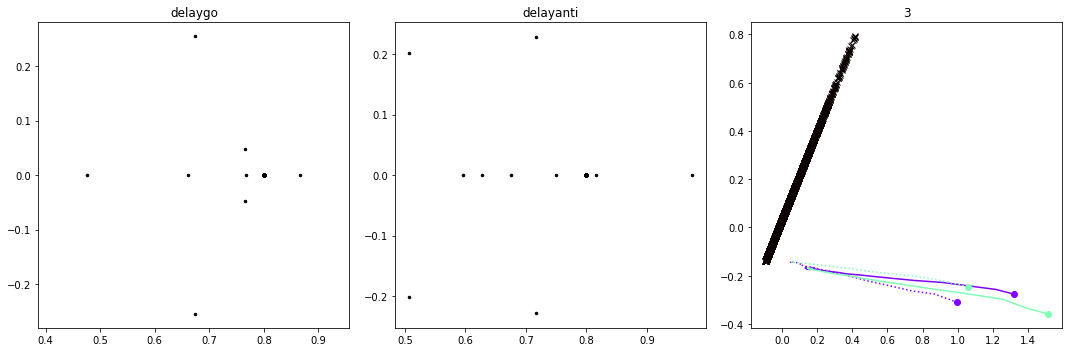

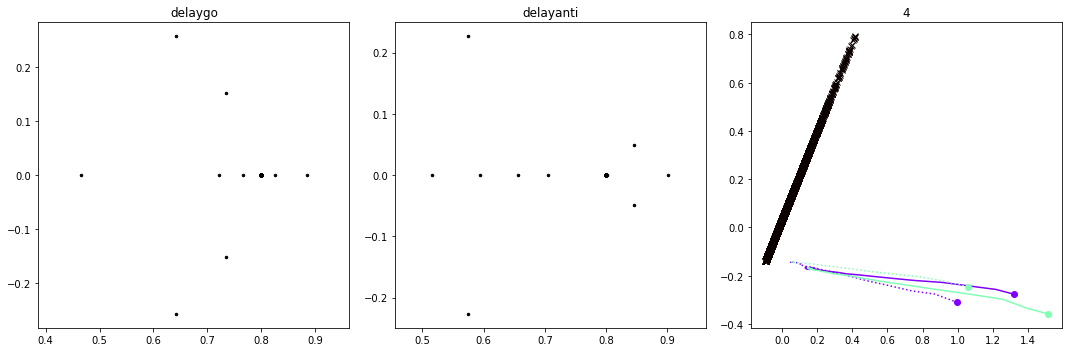

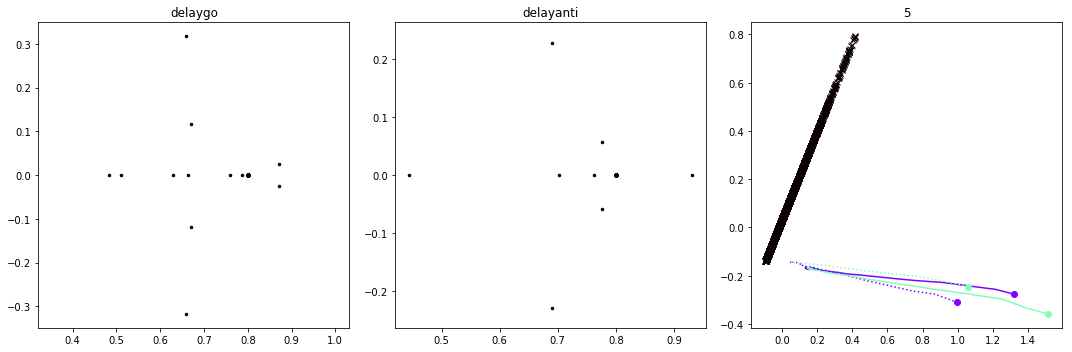

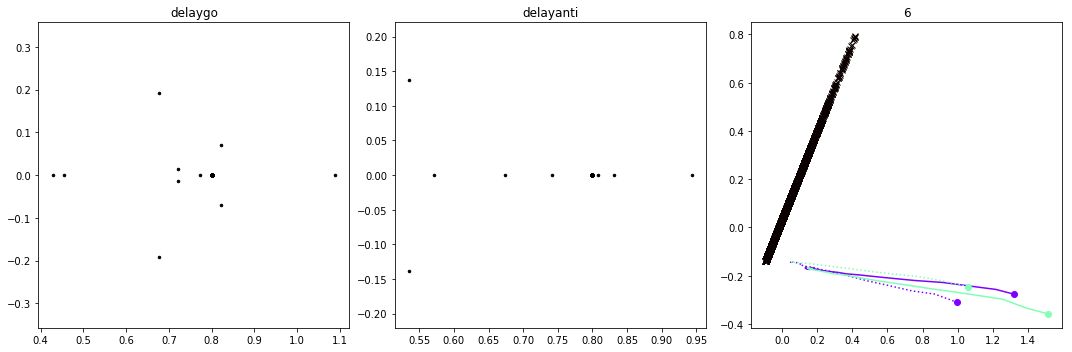

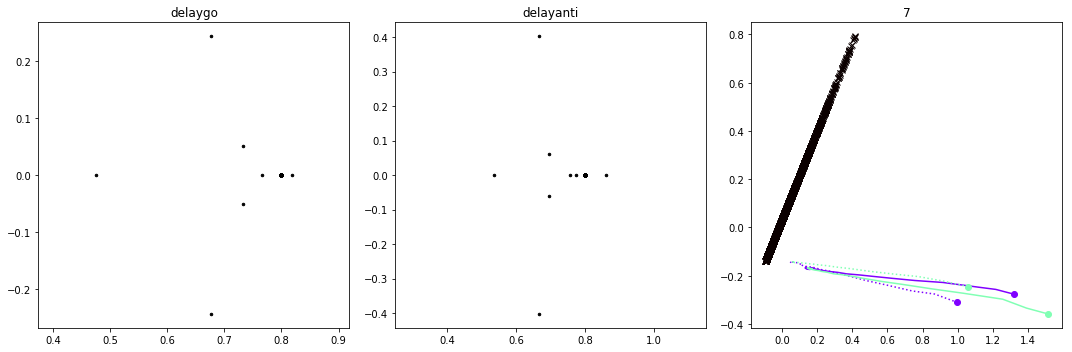

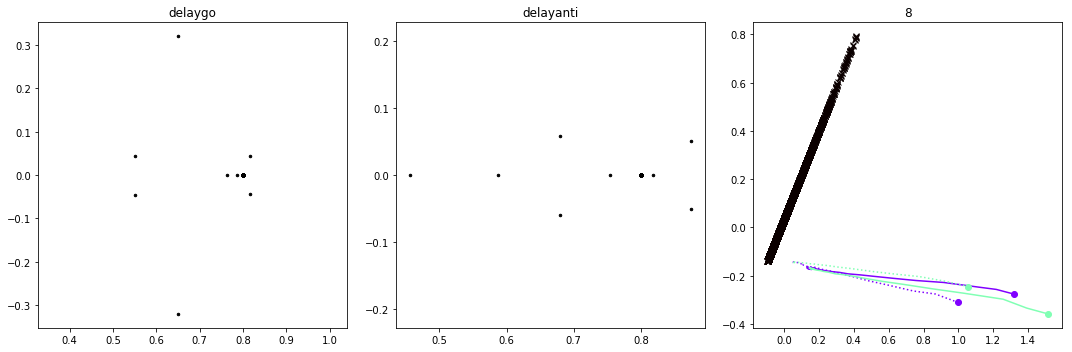

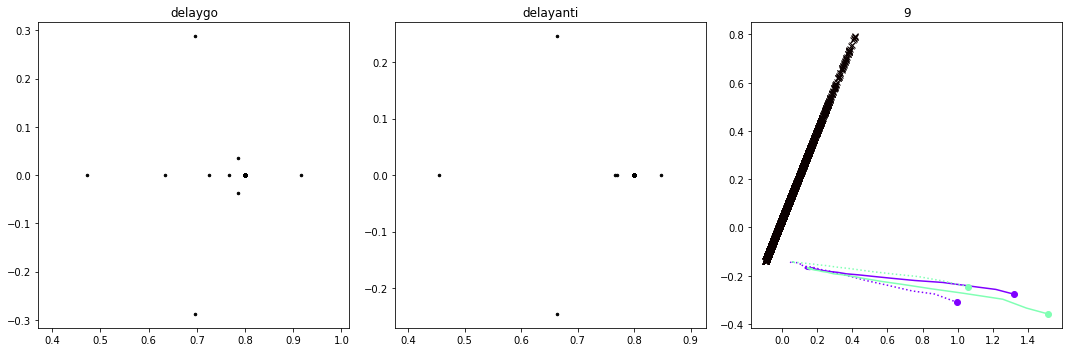

In [72]:
col = 3
for xi in range(10):
    
    fig = plt.figure(figsize=(15, 5),tight_layout=True,facecolor='white')
    
    plt.subplot(1,col,1)
    w, v = LA.eig(fpf_dict['delaygo']['J_xstar'][xi])
    plt.plot(w.real,w.imag,'.k',markersize=5)
    plt.xlim((0,1))
    plt.ylim((-.5,.5))
    plt.axis('equal')
    plt.title('delaygo')
    
    plt.subplot(1,col,2)
    w, v = LA.eig(fpf_dict['delayanti']['J_xstar'][xi])
    plt.plot(w.real,w.imag,'.k',markersize=5)
    plt.xlim((0,1))
    plt.ylim((-.5,.5))
    plt.axis('equal')
    plt.title('delayanti')
    
    plt.subplot(1,col,3)
    trial_set = range(0,200,100)
    plot_sitch(1,0,xi)
#     xstar_pca = pca.transform(np.expand_dims(fpf_dict['delaygo']['xstar'][xi],axis = 1))
#     plt.plot(xstar_pca[:,pc_ind0],xstar_pca[:,pc_ind1],'xg')
#     xstar_pca = pca.transform(np.expand_dims(fpf_dict['delayanti']['xstar'][xi],axis = 1))
#     plt.plot(xstar_pca[:,pc_ind0],xstar_pca[:,pc_ind1],'xr')
#     plt.xlim((-1.5,1.5))
#     plt.ylim((-1.5,1.5))
    plt.title(str(xi))
    plt.show()

In [56]:
print(fpf_dict['delaygo']['qstar'][0])

0.006407938


In [51]:
print(xi)

9
